# US COVID-19 Data

In [83]:
import os
import sys

from IPython.display import IFrame
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.offline as offline
import numpy as np
import missingno as msno
import seaborn as sns
import warnings
import networkx as nx
import osmnx as ox
import datetime
from datetime import date
import requests
import urllib
import zipfile
import glob

## Import data from NYTimes

The [New York Times](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html) daily shares the latest update on COVID-19 in the US. They use various data visualization tools for easier understanding of the data.  They also share all of their data on [GitHub](https://github.com/nytimes/covid-19-data).

[![ne_download_page](https://raw.githubusercontent.com/katkim0307/COVID-19_Response_Comparison/master/Data/image/nytimes_cov19_page.PNG)](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html)

### Read in US, States, and Counties data

In [13]:
nytimes_us_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
nytimes_states_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nytimes_counties_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

### US

In [98]:
nytimes_us_df = pd.read_csv(nytimes_us_url)

nytimes_us_df.tail()

,date,cases,deaths
98,2020-04-28,1012572,53034
99,2020-04-29,1039166,55399
100,2020-04-30,1069559,57570
101,2020-05-01,1103544,59392
102,2020-05-02,1133083,61077


In [29]:
nytimes_us_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    103 non-null    object
 1   cases   103 non-null    int64 
 2   deaths  103 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [32]:
nytimes_us_df['date']=pd.to_datetime(nytimes_us_df['date'])

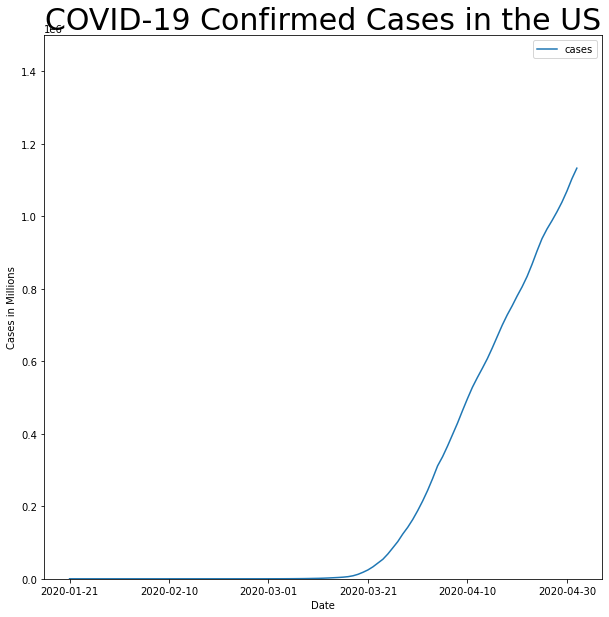

In [114]:
nytimes_us_df.plot(
    x='date',
    y='cases',
    kind='line',
    figsize=(10,10),
    ylim=(0, 1500000),
);

plt.title('COVID-19 Confirmed Cases in the US', fontdict={'size': 30})
plt.xlabel('Date')
plt.ylabel('Cases in Millions')
plt.show();

### States

In [36]:
nytimes_states_df = pd.read_csv(nytimes_states_url, dtype={'fips':object})

nytimes_states_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [37]:
nytimes_states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3369 entries, 0 to 3368
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3369 non-null   object
 1   state   3369 non-null   object
 2   fips    3369 non-null   object
 3   cases   3369 non-null   int64 
 4   deaths  3369 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 131.7+ KB


In [33]:
nytimes_states_df['date']=pd.to_datetime(nytimes_states_df['date'])

### Counties

In [39]:
nytimes_counties_df = pd.read_csv(nytimes_counties_url, dtype={'fips':object})

nytimes_counties_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [40]:
nytimes_counties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109696 entries, 0 to 109695
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    109696 non-null  object
 1   county  109696 non-null  object
 2   state   109696 non-null  object
 3   fips    108406 non-null  object
 4   cases   109696 non-null  int64 
 5   deaths  109696 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 5.0+ MB


In [34]:
nytimes_counties_df['date']=pd.to_datetime(nytimes_counties_df['date'])

## Import data from COVID-19 Tracking Project

The [COVID Tracking Project](https://covidtracking.com/) publishes the latest update on COVID-19 testing in the US and territories. They use various data visualization tools for easier understanding of the data.  [Download](https://covidtracking.com/api) their data at a national and state level.

[![ne_download_page](https://raw.githubusercontent.com/katkim0307/COVID-19_Response_Comparison/master/Data/image/cov_track_proj_page.PNG)](https://covidtracking.com/)

### Read in US Historical Data and States Historical Data

In [4]:
covtrack_us_hist_url = 'https://covidtracking.com/api/v1/us/daily.json'
covtrack_us_now_url = 'https://covidtracking.com/api/v1/us/current.json'

covtrack_states_hist_url = 'https://covidtracking.com/api/v1/states/daily.json'
covtrack_states_now_url = 'https://covidtracking.com/api/v1/states/current.json'

### US

In [53]:
covtrack_us_now_df = pd.read_json(covtrack_us_now_url)

covtrack_us_now_df

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,lastModified,death,hospitalized,total,totalTestResults,posNeg,notes
0,1152006,5901360,2812,50312,125796,9292,4502,4761,425,180152,d9bbf5d5083f4ac74e13a02578db56835078c70a,5/4/2020,61868,125796,7056178,7053366,7053366,"NOTE: ""total"", ""posNeg"", ""hospitalized"" will b..."


In [91]:
covtrack_us_hist_df = pd.read_json(covtrack_us_hist_url, dtype={'fips':object})

covtrack_us_hist_df.tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
98,20200126,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
99,20200125,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
100,20200124,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
101,20200123,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0
102,20200122,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN


In [92]:
covtrack_us_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      103 non-null    int64  
 1   states                    103 non-null    int64  
 2   positive                  103 non-null    int64  
 3   negative                  65 non-null     float64
 4   pending                   61 non-null     float64
 5   hospitalizedCurrently     48 non-null     float64
 6   hospitalizedCumulative    44 non-null     float64
 7   inIcuCurrently            39 non-null     float64
 8   inIcuCumulative           40 non-null     float64
 9   onVentilatorCurrently     40 non-null     float64
 10  onVentilatorCumulative    33 non-null     float64
 11  recovered                 40 non-null     float64
 12  hash                      103 non-null    object 
 13  dateChecked               103 non-null    object 
 14  death     

In [93]:
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['date'].astype(str), format='%Y-%m-%d')

covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['datetime'])

covtrack_us_hist_df.tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime
98,20200126,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0,2020-01-26
99,20200125,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0,2020-01-25
100,20200124,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0,2020-01-24
101,20200123,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,0.0,0.0,0.0,0.0,0.0,2020-01-23
102,20200122,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,2020-01-22


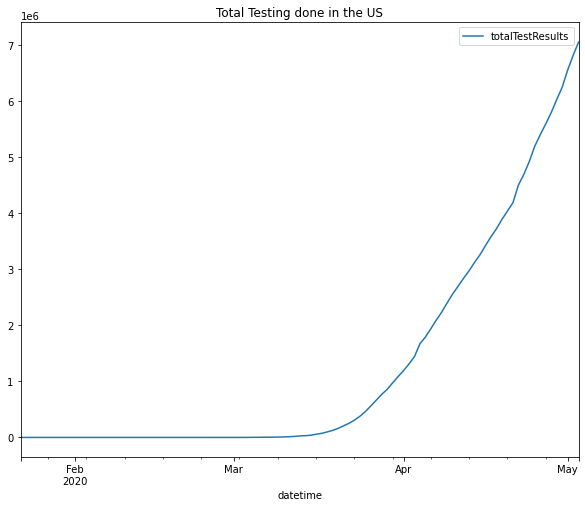

In [100]:
covtrack_us_hist_df.plot(
    x='datetime',
    y='totalTestResults',
    title='Total Testing done in the US',
    figsize=(10, 8),
);

In [95]:
covtrack_us_hist_plot = covtrack_us_hist_df[['datetime', 'positive', 'death', 'total']]
covtrack_us_hist_plot.set_index('datetime', inplace=True)

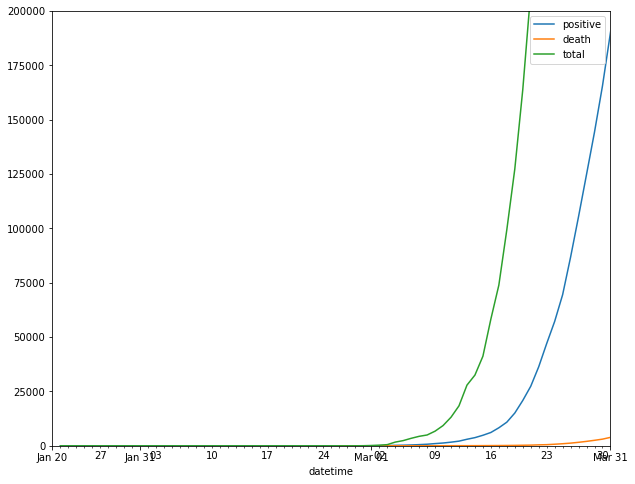

In [101]:
# plot data
fig, ax = plt.subplots(figsize=(10, 8))
covtrack_us_hist_plot.plot(ax=ax)

# set ticks every month
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# set the time limit
ax.set_xlim(['2020-1-21', '2020-3-31'])
ax.set_ylim(0, 200000)

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### States

In [56]:
covtrack_states_now_df = pd.read_json(covtrack_states_now_url)

covtrack_states_now_df.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,notes,dataQualityGrade,...,checkTimeEt,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked,hash
0,AK,371,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",C,...,5/05 15:50,9,NaN,22692,22692,22692,2,2020-05-05T04:00:00Z,2020-05-05T19:50:00Z,6e6b3b3c97df1a847380ada5dd32d02cd9627d26
1,AL,8285,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/05 16:36,313,1107.0,106766,106766,106766,1,2020-05-05T04:00:00Z,2020-05-05T20:36:00Z,dc74c063e47150b12f62c71691adfa98d712c88c
2,AR,3496,1.0,1.0,1.0,1.0,A,4.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/05 16:50,80,453.0,54635,54635,54635,5,2020-05-05T20:10:00Z,2020-05-05T20:50:00Z,285a0837d372af138883de269eae4ac2d8601bb0
3,AZ,9305,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",A+,...,5/05 16:19,395,1397.0,88260,88260,88260,4,2020-05-05T04:00:00Z,2020-05-05T20:19:00Z,4aaa265a0a77c11666b5fa8bae55a88ca8da48fb
4,CA,56212,1.0,1.0,0.0,1.0,B,3.0,"Please stop using the ""total"" field. Use ""tota...",B,...,5/05 16:27,2317,NaN,779902,779902,779902,6,2020-05-05T18:00:00Z,2020-05-05T20:27:00Z,807b34e443783d7ac53cfdafa1eea12119b604db


In [35]:
covtrack_states_now_df.shape

(56, 30)

In [57]:
covtrack_states_hist_df = pd.read_json(covtrack_states_hist_url, dtype={'fips':object})[
    ['date', 'state', 'fips', 'positive', 'death', 'total']
]

covtrack_states_hist_df.head()

,date,state,fips,positive,death,total
0,20200505,AK,02,371.0,9.0,22692
1,20200505,AL,01,8285.0,313.0,106766
2,20200505,AR,05,3496.0,80.0,54635
3,20200505,AS,60,0.0,0.0,83
4,20200505,AZ,04,9305.0,395.0,88260


In [58]:
covtrack_states_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3433 entries, 0 to 3432
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      3433 non-null   int64  
 1   state     3433 non-null   object 
 2   fips      3433 non-null   object 
 3   positive  3418 non-null   float64
 4   death     2706 non-null   float64
 5   total     3433 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 161.0+ KB


In [59]:
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['date'].astype(str), format='%Y-%m-%d')

covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['datetime'])

covtrack_states_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3433 entries, 0 to 3432
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      3433 non-null   int64         
 1   state     3433 non-null   object        
 2   fips      3433 non-null   object        
 3   positive  3418 non-null   float64       
 4   death     2706 non-null   float64       
 5   total     3433 non-null   int64         
 6   datetime  3433 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 187.9+ KB


In [60]:
covtrack_states_hist_df.tail()

,date,state,fips,positive,death,total,datetime
3428,20200126,WA,53,1.0,NaN,1,2020-01-26
3429,20200125,WA,53,1.0,NaN,1,2020-01-25
3430,20200124,WA,53,1.0,NaN,1,2020-01-24
3431,20200123,WA,53,1.0,NaN,1,2020-01-23
3432,20200122,WA,53,1.0,NaN,1,2020-01-22


# Data Visualisation
### by US States `covtrack_state_hist_df` or `us_cov19_states_gdf` 
Interactive Map 2: https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu

### First merge `covtrack_state_hist_df` with `us_tates_gdf`

In [52]:
# Read US States Boundary Shapefile
us_states_gdf = gpd.read_file('Data/input/us_state/cb_2018_us_state_5m.shp')

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_states_gdf.to_crs(epsg=2163, inplace=True)

# Adding a column 'coords' for later use (labeling each State)
us_states_gdf['coords'] = us_states_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
us_states_gdf['coords'] = [coords[0] for coords in us_states_gdf['coords']]

In [61]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_df = pd.merge(
    covtrack_states_hist_df,
    us_states_gdf[['STATEFP', 'NAME', 'coords', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

In [67]:
us_cov19_states_df.head()

,date,state,fips,positive,death,total,datetime,STATEFP,NAME,coords,geometry
0,20200505,AK,02,371.0,9.0,22692,2020-05-05,02,Alaska,"(-2180339.847699951, 2622589.4473532755)","MULTIPOLYGON (((-4288629.978 3426273.416, -428..."
1,20200505,AL,01,8285.0,313.0,106766,2020-05-05,01,Alabama,"(1249493.1603794529, -1279834.742587857)","MULTIPOLYGON (((1150023.442 -1526367.945, 1150..."
2,20200505,AR,05,3496.0,80.0,54635,2020-05-05,05,Arkansas,"(685109.6121825308, -1101604.851975698)","POLYGON ((482000.986 -928930.836, 487242.080 -..."
3,20200505,AS,60,0.0,0.0,83,2020-05-05,60,American Samoa,"(-8034589.865696663, -3524671.326840096)","MULTIPOLYGON (((-7800567.112 -3751033.523, -78..."
4,20200505,AZ,04,9305.0,395.0,88260,2020-05-05,04,Arizona,"(-1085734.3498492904, -1127761.0539318295)","POLYGON ((-1386135.563 -1256471.688, -1386636...."


### Let's start by plotting a single day on a map of the US, and they you will build from there.

In [88]:
# import datetime
state_start_date = datetime.datetime(2020, 5, 4)

state_start_df = us_cov19_states_df[(us_cov19_states_df['datetime']==state_start_date)]

In [89]:
state_start_df.head()

,date,state,fips,positive,death,total,datetime,STATEFP,NAME,coords,geometry
56,20200504,AK,02,370.0,9.0,21723,2020-05-04,02,Alaska,"(-2180339.847699951, 2622589.4473532755)","MULTIPOLYGON (((-4288629.978 3426273.416, -428..."
57,20200504,AL,01,8025.0,296.0,103117,2020-05-04,01,Alabama,"(1249493.1603794529, -1279834.742587857)","MULTIPOLYGON (((1150023.442 -1526367.945, 1150..."
58,20200504,AR,05,3458.0,81.0,54442,2020-05-04,05,Arkansas,"(685109.6121825308, -1101604.851975698)","POLYGON ((482000.986 -928930.836, 487242.080 -..."
59,20200504,AS,60,0.0,0.0,83,2020-05-04,60,American Samoa,"(-8034589.865696663, -3524671.326840096)","MULTIPOLYGON (((-7800567.112 -3751033.523, -78..."
60,20200504,AZ,04,8919.0,362.0,85253,2020-05-04,04,Arizona,"(-1085734.3498492904, -1127761.0539318295)","POLYGON ((-1386135.563 -1256471.688, -1386636...."


In [90]:
# color scheme for the map plot (white to red)
state_color_scale = ['#FFEBEE', '#FFCDD2', '#EF9A9A', '#E57373', '#EF5350', 
                      '#F44336', '#E53935', '#D32F2F', '#C62828', '#B71C1C']

# state_color_scale = [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'],
#                      [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']]

# creating a new column that will include the mouse-hovering text for each state
for col in state_start_df.columns:
    state_start_df[col] = state_start_df[col].astype(str)

state_start_df['text'] = state_start_df['NAME'] + '<br>' + \
                        'Cases: ' + state_start_df['positive'] + '<br>' + \
                        'Deaths: ' + state_start_df['death'] + '<br>' + \
                        'Tests: ' + state_start_df['total']

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
# data object for plotting

data = [ dict(
            type='choropleth', # type of map-plot
            #scheme='boxplot',
            colorscale = state_color_scale,
            autocolorscale = False,
            locations = state_start_df['state'], # the column with the state post code
            z = state_start_df['positive'].astype(float), # the variable I want to color-code
            locationmode = 'USA-states',
            text = state_start_df['text'], # hover text
            marker = dict(     # for the lines separating states
                        line = dict (
                                  color = 'rgb(255,255,255)', 
                                  width = 2) ),               
            colorbar = dict(
                        title = "Confirmed Cases")
            ) 
       ]

# creating a fig object for plotting
# fig = go.Figure(data=go.Choropleth(
#     locations=state_start_df['fips'],  # the column with the county fips
#     z = state_start_df['positive'].astype(float),  # the variable I want to color-code
#     locationmode = 'USA-states',
#     colorscale = county_color_scale,
#     autocolorscale = False,
#     text = state_start_df['text'], # hover text
#     marker_line_color = 'white'     # for the lines separating states
#     marker_linewidth = 2,    
#     colorbar_title = 'COVID-19 Confirmed Cases'
# ))


In [98]:
# layout
layout = dict(
        title = 'US COVID-19 Confirmed Cases (latest update: ' + state_start_date.strftime('%b %d') + ')',
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            # showlakes = True,  # if you want to give color to the lakes
            # lakecolor = 'rgb(73, 216, 230)'  
            ),
        )


fig = dict(data=data, layout=layout)


# plot
plotly.offline.iplot(fig)

# if want to plot in a different window on your browser
# offline.plot(
#     fig, 
#     auto_open=True, 
#     image = 'png', 
#     image_filename="US State COVID-19 Confirmed Cases"+str(state_start_date.strftime('%b %d')),  
#     image_width=2000, image_height=1000, 
#     filename='/your_path/'/span>"US State COVID-19 Confirmed Cases"str(state_start_date.strftime('%b %d'))+'.html', validate=True)


# updating the layout
# fig.update_layout(
#     title_text = 'US COVID-19 Confirmed Cases (latest update: ' + state_start_date['datetime'].strftime('%b %d') + ')',
#     geo = dict(
#             scope = 'usa',
#             projection=go.layout.geo.Projection(type='albers usa'),
#             # showlakes = True,  # if you want to give color to the lakes
#             # lakecolor = 'rgb(73, 216, 230)'
#     )
# )

# fig.show()


### You have the plot for the first confirmed COVID-19 case in the US!  Now we can make the necessary modifications to add a slider to go over the different days in the data set.  The main conceptual differences are that now the data object now is going to be a list of dictionaries, and also that I need to create a ‘steps’, and a ‘slider’ object that will go as an argument for the layout command.

In [ ]:
# create an empty list for data object
data_slider = []

# populate the data object, one dictionary per day that will be displayed with the slider, by iterating over the different years in the data set
for day in us_cov19_states_df.datetime.unique():
    
    # select the date
    # state_start_df = us_cov19_states_df[us_cov19_states_df['datetime']==start_date]
    
    # transform the column into string type for hovering text
    # for col in state_start_df.columns:
    #     state_start_df[col] = state_start_df[col].astype(str)







